In [2]:
import pandas as pd

# load CSV file with python engine to handle potential parsing issues
df = pd.read_csv("/content/fake reviews dataset.csv", engine='python', on_bad_lines='skip')

# see first 5 rows
print(df.head())

             category  rating label  \
0  Home_and_Kitchen_5     5.0    CG   
1  Home_and_Kitchen_5     5.0    CG   
2  Home_and_Kitchen_5     5.0    CG   
3  Home_and_Kitchen_5     1.0    CG   
4  Home_and_Kitchen_5     5.0    CG   

                                               text_  
0  Love this!  Well made, sturdy, and very comfor...  
1  love it, a great upgrade from the original.  I...  
2  This pillow saved my back. I love the look and...  
3  Missing information on how to use it, but it i...  
4  Very nice set. Good quality. We have had the s...  


In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# download resources (only once)
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):   # handle missing values
        return ""
    text = text.lower()                             # lowercase
    text = re.sub(r'http\S+|www\S+', '', text)      # remove URLs
    text = re.sub(r'[^a-z\s]', ' ', text)           # remove numbers/punctuation
    tokens = text.split()                           # tokenize
    tokens = [t for t in tokens if t not in stop_words]  # remove stopwords
    tokens = [lemmatizer.lemmatize(t) for t in tokens]   # lemmatize
    return " ".join(tokens)


In [7]:
df['clean_review'] = df['text_'].apply(clean_text)
print(df[['text_', 'clean_review']].head())

                                               text_  \
0  Love this!  Well made, sturdy, and very comfor...   
1  love it, a great upgrade from the original.  I...   
2  This pillow saved my back. I love the look and...   
3  Missing information on how to use it, but it i...   
4  Very nice set. Good quality. We have had the s...   

                                    clean_review  
0  love well made sturdy comfortable love pretty  
1   love great upgrade original mine couple year  
2        pillow saved back love look feel pillow  
3    missing information use great product price  
4            nice set good quality set two month  


In [14]:
df['label_enc'] = df['label'].map({'CG':0, 'OR':1})
print(df[['clean_review', 'label_enc']].head())
print(df.isnull().sum())   # check for missing values

                                    clean_review  label_enc
0  love well made sturdy comfortable love pretty          0
1   love great upgrade original mine couple year          0
2        pillow saved back love look feel pillow          0
3    missing information use great product price          0
4            nice set good quality set two month          0
category        0
rating          0
label           0
text_           0
clean_review    0
label_enc       0
dtype: int64


In [15]:
from sklearn.model_selection import train_test_split
X = df['clean_review']    # preprocessed reviews
y = df['label_enc']       # encoded labels (0 = genuine, 1 = fake)

# Drop rows with NaN in the target variable
df_cleaned = df.dropna(subset=['label_enc'])
X = df_cleaned['clean_review']
y = df_cleaned['label_enc']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% test, 80% train
    random_state=42,     # ensures reproducibility
    stratify=y           # keeps same class balance in train & test
)
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 32345
Test set size: 8087


In [13]:
print(df['label'].unique())

['CG' 'OR']


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)   # learn vocab from training
X_test_tfidf = vectorizer.transform(X_test)         # transform test with same vocab
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)
print(vectorizer.get_feature_names_out()[:20])


Train TF-IDF shape: (32345, 5000)
Test TF-IDF shape: (8087, 5000)
['aa' 'aaa' 'ab' 'abandoned' 'abbey' 'ability' 'able' 'abrupt' 'abruptly'
 'absolute' 'absolutely' 'absorb' 'absorbed' 'absorbent' 'abuse' 'abused'
 'abusive' 'ac' 'academic' 'academy']


In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Initialize model
nb_model = MultinomialNB()

# Train on training data
nb_model.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate

print(classification_report(y_test, y_pred_nb, target_names=["Genuine", "Fake"]))
# Initialize model
lr_model = LogisticRegression(max_iter=200)

# Train
lr_model.fit(X_train_tfidf, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluate

print(classification_report(y_test, y_pred_lr, target_names=["Genuine", "Fake"]))


              precision    recall  f1-score   support

     Genuine       0.81      0.87      0.84      4044
        Fake       0.86      0.79      0.82      4043

    accuracy                           0.83      8087
   macro avg       0.83      0.83      0.83      8087
weighted avg       0.83      0.83      0.83      8087

              precision    recall  f1-score   support

     Genuine       0.86      0.84      0.85      4044
        Fake       0.84      0.86      0.85      4043

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087



In [19]:
import joblib

# Save vectorizer & model
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")
joblib.dump(lr_model, "fake_review_model.joblib")  # or nb_model if better


['fake_review_model.joblib']

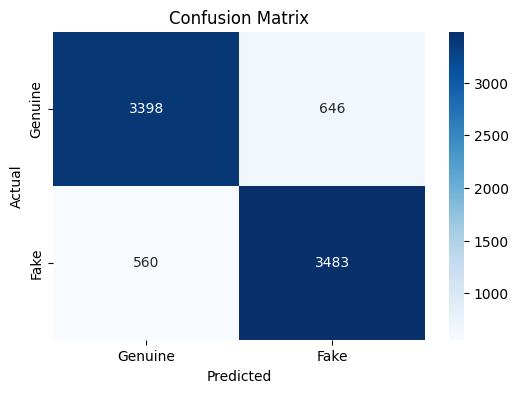

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
y_pred = lr_model.predict(X_test_tfidf)  # or nb_model.predict(...)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Genuine", "Fake"],
            yticklabels=["Genuine", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [21]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Genuine", "Fake"]))


Accuracy: 0.8508717695066156

Classification Report:

              precision    recall  f1-score   support

     Genuine       0.86      0.84      0.85      4044
        Fake       0.84      0.86      0.85      4043

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087

